In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

#### Importing the dataset

rating_dataset is the Surprise dataset that can be used when analyzing the full dataset.
<br>
rating_matrix is the numpy array that has columns: userId, movieId, rating, timestamp

In [21]:
from surprise import Reader, Dataset

In [22]:
# Read data set using pandas and surprise. Data is stored in rating_dataset

df=pd.read_csv('ml-latest-small/ratings.csv')
# reader = Reader(rating_scale=(1,5))
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(0.5, 5), skip_lines=1)

rating_dataset = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
rating_matrix = df.values

# Get the all ratings for each movie. Key is movie ID, value of an array of ratings.
ratings_by_movie_id = {}
for row in rating_dataset.raw_ratings:
    if row[1] not in ratings_by_movie_id:
        ratings_by_movie_id[row[1]] = []
    ratings_by_movie_id[row[1]].append(row[2])

# Count number of users and movies.
num_users = np.size(np.unique(rating_matrix[:,0]))
num_movies = np.size(np.unique(rating_matrix[:,1]))

##### Build R Matrix

In [23]:
R = np.zeros([num_users, num_movies])

ratings = np.genfromtxt('ml-latest-small/ratings.csv', delimiter=',')
ratings = np.delete(ratings, (0), axis=0) # Remove column title row
ratings = np.delete(ratings, (3), axis=1) # Remove time stamp column

# Create a dictionary where the key is the movie id and the value is the location in data

movie_ids = {}
counter = 0
for rating in ratings:
    if rating[1] not in movie_ids.keys():
        movie_ids[rating[1]] = counter
        counter += 1
        
# Put ratings into a matrix of size num_users x num_movies. 
# To get the rating of a user for a specific movie, do data[userId - 1, movie_ids[movieId]]

for rating in ratings:
    user = int(rating[0]) - 1
    movie = int(movie_ids[rating[1]])
    R[user, movie] = rating[2]
    
print(R)

[[4.  4.  4.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.5 2.  0.  ... 0.  0.  0. ]
 [3.  0.  0.  ... 0.  0.  0. ]
 [5.  0.  5.  ... 3.  3.5 3.5]]


#### Question 1

In [24]:
# Calculate sparsity, defined as: (total number of available ratings) / (total number of possible ratings)

num_available_ratings = np.size(rating_matrix[:,0])
num_possible_ratings = num_users*num_movies

sparsity = num_available_ratings / num_possible_ratings

print('Sparsity = {}'.format(sparsity))

Sparsity = 0.016999683055613623


#### Question 2

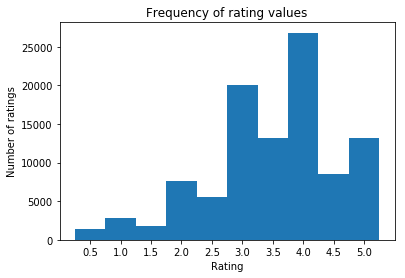

In [25]:
# Plot a histogram showing the frequency of rating values

ratings = rating_matrix[:,2]
plt.figure()
# plt.hist(ratings, 10)
plt.hist(ratings, np.arange(0.5, 6, 0.5))
plt.title('Frequency of rating values')
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.xticks(np.arange(0.75, 5.75, 0.5), np.arange(0.5, 5.5, 0.5))
plt.show()

#### Question 3

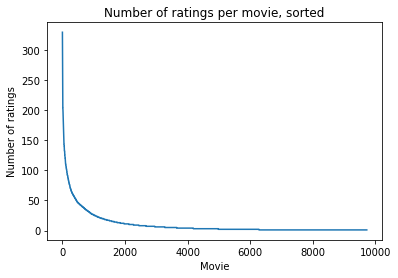

In [26]:
# Distribution of number of ratings received per movie.

movies = rating_matrix[:,1]
movie_id, counts = np.unique(movies, return_counts=True)
counts_sorted = np.sort(counts)[::-1]

plt.figure()
plt.plot(counts_sorted)
plt.title('Number of ratings per movie, sorted')
plt.xlabel('Movie')
plt.ylabel('Number of ratings')
plt.show()

#### Question 4

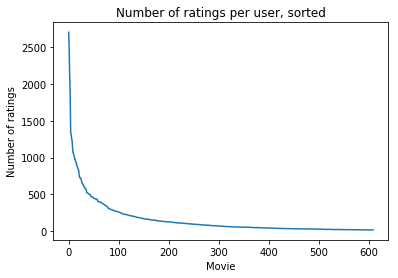

In [27]:
# Distribution of number of ratings given per user

users = rating_matrix[:,0]
user_id, counts = np.unique(users, return_counts=True)
counts_sorted = np.sort(counts)[::-1]

plt.figure()
plt.plot(counts_sorted)
plt.title('Number of ratings per user, sorted')
plt.xlabel('Movie')
plt.ylabel('Number of ratings')
plt.show()

#### Question 6

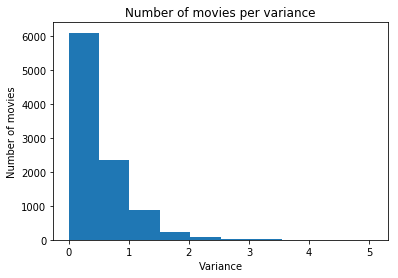

In [28]:
# Histogram of variance in ratings per movie

var_by_movie_id = {}
for key in ratings_by_movie_id.keys():
    var_by_movie_id[key] = np.var(ratings_by_movie_id[key])
    
variances = list(var_by_movie_id.values())

plt.figure()
plt.hist(variances)
plt.title('Number of movies per variance')
plt.xlabel('Variance')
plt.ylabel('Number of movies')
plt.show()

#### Trimming the dataset

The trimmed data set is in a format the Surprise can take as input.

##### Variable names:
Popular movie dataset: rating_popular_dataset 
<br>
Unpopular movie dataset: rating_unpopular_dataset
<br>
High variance movie dataset: rating_highvar_dataset

In [29]:
# # Get the movie ids that are being kept in each trimming. 

# ratings_by_movie_id = {}
# for row in rating_dataset.raw_ratings:
#     if row[1] not in ratings_by_movie_id:
#         ratings_by_movie_id[row[1]] = []
#     ratings_by_movie_id[row[1]].append(row[2])

# var_by_movie_id = {}
# for key in ratings_by_movie_id.keys():
#     var_by_movie_id[key] = np.var(ratings_by_movie_id[key])
    
# pop_movie_ids = [k for k in ratings_by_movie_id if len(ratings_by_movie_id[k]) > 2]
# unpop_movie_ids = [k for k in ratings_by_movie_id if len(ratings_by_movie_id[k]) <= 2]
# highvar_movie_ids = [k for k in var_by_movie_id if var_by_movie_id[k] >= 2 and len(ratings_by_movie_id[k]) >= 5]

In [30]:
# # Make a new dataframe for each trimmed set.

# df = pd.read_csv('ml-latest-small/ratings.csv')
# df_popular = df[df['movieId'].isin(pop_movie_ids)]
# df = pd.read_csv('ml-latest-small/ratings.csv')
# df_unpopular = df[df['movieId'].isin(unpop_movie_ids)]
# df = pd.read_csv('ml-latest-small/ratings.csv')
# df_highvar = df[df['movieId'].isin(highvar_movie_ids)]

In [31]:
# # Make a new surprise Dataset for each trimmed set.

# rating_popular_dataset = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)
# rating_unpopular_dataset = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)
# rating_highvar_dataset = Dataset.load_from_df(df_highvar[['userId', 'movieId', 'rating']], reader)

In [32]:
def get_popular(testset):
    ratings_by_movie_id = {}
    for row in testset:
        if row[1] not in ratings_by_movie_id:
            ratings_by_movie_id[row[1]] = []
        ratings_by_movie_id[row[1]].append(row[2])
    testset_pop = [k for k in testset if len(ratings_by_movie_id[k[1]]) > 2]
    return testset_pop

In [33]:
def get_unpopular(testset):
    ratings_by_movie_id = {}
    for row in testset:
        if row[1] not in ratings_by_movie_id:
            ratings_by_movie_id[row[1]] = []
        ratings_by_movie_id[row[1]].append(row[2])
    testset_unpop = [k for k in testset if len(ratings_by_movie_id[k[1]]) <= 2]
    return testset_unpop

In [34]:
def get_highvar(testset):
    ratings_by_movie_id = {}
    for row in testset:
        if row[1] not in ratings_by_movie_id:
            ratings_by_movie_id[row[1]] = []
        ratings_by_movie_id[row[1]].append(row[2])
    var_by_movie_id = {}
    for key in ratings_by_movie_id.keys():
        var_by_movie_id[key] = np.var(ratings_by_movie_id[key])
    testset_highvar = [k for k in testset if len(ratings_by_movie_id[k[1]]) >= 5 and var_by_movie_id[k[1]] >= 2]
    return testset_highvar

#### Trimming the data set

In [19]:
# # Popular movie trimming

# nz_movie = np.count_nonzero(data, axis=0)
# unpop_movies = []
# for i in range(len(nz_movie)):
#     if nz_movie[i] <= 2:
#         unpop_movies.append(i)

# data_popular = np.delete(data, unpop_movies, axis=1)
# # print(np.unique(np.count_nonzero(data_popular, axis=0)))
# # print(data_popular)

In [20]:
# # Unpopular movie trimming

# nz_movie = np.count_nonzero(data, axis=0)
# pop_movies = []
# for i in range(len(nz_movie)):
#     if nz_movie[i] > 2:
#         pop_movies.append(i)
        
# data_unpopular = np.delete(data, pop_movies, axis=1)
# # print(np.unique(np.count_nonzero(data_unpopular, axis=0)))

In [21]:
# # High variance movie trimming

# nz_movie = np.count_nonzero(data, axis=0)
# movies_less5 = []
# for i in range(len(nz_movie)):
#     if nz_movie[i] < 5:
#         movies_less5.append(i)

# data_more5 = np.delete(data, movies_less5, axis=1)

# variances = np.zeros(np.shape(data_more5)[1])
# for i in range(np.shape(data_more5)[1]):
#     variances[i] = np.var(data_more5[:, i])

# lowvar_movies = []
# for i in range(np.shape(data_more5)[1]):
#     if variances[i] < 2:
#         lowvar_movies.append(i)
# data_highvar = np.delete(data_more5, lowvar_movies, axis=1)

# # print(data_highvar.shape)
# # print(np.var(data_highvar[:,13]))

## Question 10

In [23]:
from surprise import KNNBasic, KNNWithMeans
from surprise import evaluate
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

In [24]:
ks = np.arange(2, 101, 2)

In [30]:
# Analyze full dataset

rmse_scores = []
mae_scores = []

for k in ks:
    knn = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    result = cross_validate(knn, rating_dataset, measures=['rmse', 'mae'], cv=10)
    
    rmse = np.mean(result['test_rmse'])
    mae = np.mean(result['test_mae'])
    
    print('k = {}'.format(k))
    print(rmse)
    print(mae)
    print(' ')
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)

k = 2
1.0184784886072071
0.7867389335117865
 
k = 4
0.9443883337834829
0.7253886747503475
 
k = 6
0.9197742801056188
0.7043214062830897
 
k = 8
0.9078206665733918
0.6943246972896198
 
k = 10
0.9020262958939986
0.6887616180874275
 
k = 12
0.8981403393599171
0.6855244335015311
 
k = 14
0.8944811642435339
0.682197217082219
 
k = 16
0.8944167074922836
0.681915668603867
 
k = 18
0.8924095647737659
0.6801801037732494
 
k = 20
0.8907141498147191
0.6792390798464457
 
k = 22
0.8912884680642504
0.6784502114592312
 
k = 24
0.8916128571292725
0.6790648984647258
 
k = 26
0.8902068145707241
0.6779558307871815
 
k = 28
0.8910417694439076
0.6784807436693474
 
k = 30
0.889462677102712
0.6774271463003507
 
k = 32
0.8900515418480672
0.6779444105083013
 
k = 34
0.8894957080689354
0.6774274708154111
 
k = 36
0.8887368602935952
0.6768147318002083
 
k = 38
0.8889100840129112
0.6770873207646508
 
k = 40
0.8905189712087914
0.6779229164805816
 
k = 42
0.8893776098561224
0.6772350781502129
 
k = 44
0.88976395967

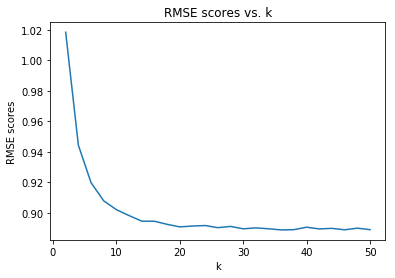

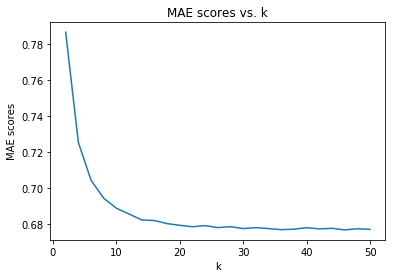

In [31]:
plt.figure()
plt.plot(ks, rmse_scores)
plt.title('RMSE scores vs. k')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

plt.figure()
plt.plot(ks, mae_scores)
plt.title('MAE scores vs. k')
plt.xlabel('k')
plt.ylabel('MAE scores')
plt.show()

## Question 11

In [32]:
# Finding the minimum k -- I think this has to be done by observing the graph and not through code.
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_scores)]))
print('Best k for MAE: {}'.format(ks[np.argmin(mae_scores)]))

Best k for RMSE: 36
Best k for MAE: 46


## Question 12

In [33]:
# Analyze popular dataset.

rmse_popular_scores = []

for k in ks:
    knn = KNNWithMeans(k=k, min_k=1, sim_options={'name': 'pearson', 'user_based': True}, verbose=False)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        knn.fit(trainset)
        predictions = knn.test(pop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_popular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.0197912491075052
 
k = 4
0.9271429076408066
 
k = 6
0.9011765767910171
 
k = 8
0.8833385270711936
 
k = 10
0.8730601270143202
 
k = 12
0.8697947629216995
 
k = 14
0.8646393724850621
 
k = 16
0.8630200194539317
 
k = 18
0.860832010859457
 
k = 20
0.8603464562980168
 
k = 22
0.8573437587316362
 
k = 24
0.8586328011955713
 
k = 26
0.8585515337838474
 
k = 28
0.8570471299138207
 
k = 30
0.8562781055076153
 
k = 32
0.858042299833951
 
k = 34
0.8566583595680886
 
k = 36
0.8582389397371617
 
k = 38
0.8577831621653553
 
k = 40
0.8565188212783811
 
k = 42
0.855893290079074
 
k = 44
0.8553318523883375
 
k = 46
0.8558899681541133
 
k = 48
0.8589011576739436
 
k = 50
0.854870544584356
 


### NMF

In [22]:
from surprise import NMF
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

#### Question 17, 18

In [23]:
ks = np.arange(2, 51, 2)

In [18]:
# from surprise.model_selection import KFold

# nmf = NMF(n_factors=2)
# kf = KFold(n_splits=10)
# for trainset, testset in kf.split(rating_dataset):
#     pop_testset = get_popular(testset)
#     nmf.fit(trainset)
#     predictions = nmf.test(testset)
#     print(accuracy.rmse(predictions, verbose=True))

In [16]:
# Analyze full dataset

rmse_scores = []
mae_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    result = cross_validate(nmf, rating_dataset, measures=['rmse', 'mae'], cv=10)
    
    rmse = np.mean(result['test_rmse'])
    mae = np.mean(result['test_mae'])
    
    print('k = {}'.format(k))
    print(rmse)
    print(mae)
    print(' ')
    
    rmse_scores.append(rmse)
    mae_scores.append(mae)

k = 2
1.1471587978469011
0.9652002658409709
 
k = 4
1.0400420163845507
0.8497487074499291
 
k = 6
0.9822175109419549
0.7856231494540006
 
k = 8
0.951144345624445
0.7498480673493013
 
k = 10
0.9305142125101364
0.7240387539799527
 
k = 12
0.9221341277510554
0.7118202243261308
 
k = 14
0.915126596509786
0.7027557604634976
 
k = 16
0.9135038852969934
0.6972617000463102
 
k = 18
0.9143230129465161
0.6958597863667213
 
k = 20
0.916385713897904
0.6952894161435672
 
k = 22
0.9174105508209133
0.6949106506170126
 
k = 24
0.9191663806383419
0.6949038465219161
 
k = 26
0.9219830920595203
0.6961144136649525
 
k = 28
0.9249354005604117
0.6974370960445719
 
k = 30
0.9331806891104766
0.7029085624426488
 
k = 32
0.9329709935859066
0.7027337360565277
 
k = 34
0.9386926332322352
0.7074248507000492
 
k = 36
0.9408453662804692
0.7085215398081093
 
k = 38
0.946005976920059
0.7126024369557491
 
k = 40
0.9508574368147054
0.7156567917366685
 
k = 42
0.9544968314931712
0.7190101611029408
 
k = 44
0.955431647468

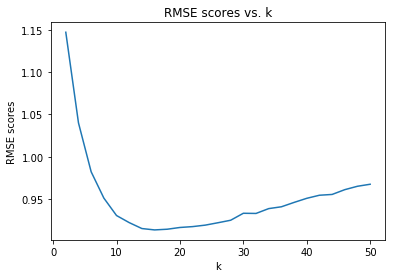

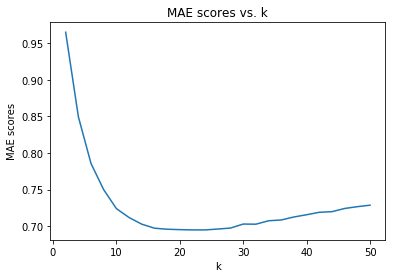

In [17]:
plt.figure()
plt.plot(ks, rmse_scores)
plt.title('RMSE scores vs. k')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

plt.figure()
plt.plot(ks, mae_scores)
plt.title('MAE scores vs. k')
plt.xlabel('k')
plt.ylabel('MAE scores')
plt.show()

In [18]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_scores)]))
print('Best k for MAE: {}'.format(ks[np.argmin(mae_scores)]))

Best k for RMSE: 16
Best k for MAE: 24


#### Question 19

In [27]:
# Analyze popular dataset.

rmse_popular_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        pop_testset = get_popular(testset)
        nmf.fit(trainset)
        predictions = nmf.test(pop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_popular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.1394935387821319
 
k = 4
1.0166910134607927
 
k = 6
0.9468737290502276
 
k = 8
0.9117048225858024
 
k = 10
0.8900826387468779
 
k = 12
0.8788492352098398
 
k = 14
0.8739220841566748
 
k = 16
0.8712306069162177
 
k = 18
0.8736318621606716
 
k = 20
0.8750547155089275
 
k = 22
0.8779841140011309
 
k = 24
0.8844191156564154
 
k = 26
0.8875362511459606
 
k = 28
0.8936199017246758
 
k = 30
0.8971067194239863
 
k = 32
0.9030655085869679
 
k = 34
0.9063305994760855
 
k = 36
0.9115209592434057
 
k = 38
0.9159813824764065
 
k = 40
0.9208056135617738
 
k = 42
0.9246613963965566
 
k = 44
0.9312240708477024
 
k = 46
0.9355008037094155
 
k = 48
0.939121458867222
 
k = 50
0.9429701746225587
 


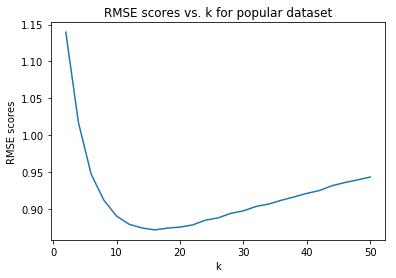

In [28]:
plt.figure()
plt.plot(ks, rmse_popular_scores)
plt.title('RMSE scores vs. k for popular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [29]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_popular_scores)]))

Best k for RMSE: 16


#### Question 20

In [41]:
# Analyze unpopular dataset

rmse_unpopular_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        unpop_testset = get_unpopular(testset)
        nmf.fit(trainset)
        predictions = nmf.test(unpop_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_unpopular_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.163448423867633
 
k = 4
1.0904447550450094
 
k = 6
1.051801207425589
 
k = 8
1.027150266923996
 
k = 10
1.0128746676512796
 
k = 12
1.0039748294730417
 
k = 14
0.9998706673476214
 
k = 16
0.9937723890234379
 
k = 18
0.9952232511212774
 
k = 20
0.9936346509622771
 
k = 22
0.9951899508719869
 
k = 24
0.9952718863807665
 
k = 26
0.994437353656755
 
k = 28
0.9964202215936137
 
k = 30
0.9968395986173064
 
k = 32
1.0037045836757308
 
k = 34
1.0003114285363632
 
k = 36
1.0040680278067662
 
k = 38
1.0064496457767356
 
k = 40
1.0071666575399747
 
k = 42
1.008173164698059
 
k = 44
1.0134141602481848
 
k = 46
1.0085650944114444
 
k = 48
1.0099396062389596
 
k = 50
1.0168248260123287
 


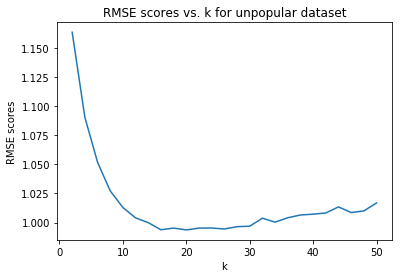

In [42]:
plt.figure()
plt.plot(ks, rmse_unpopular_scores)
plt.title('RMSE scores vs. k for unpopular dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [43]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_unpopular_scores)]))

Best k for RMSE: 20


#### Question 21

In [44]:
# Analyze high variance dataset

rmse_highvar_scores = []

for k in ks:
    nmf = NMF(n_factors=k)
    kf = KFold(n_splits=10)
    rmse_per_fold = []
    for trainset, testset in kf.split(rating_dataset):
        highvar_testset = get_highvar(testset)
        nmf.fit(trainset)
        predictions = nmf.test(highvar_testset)
        rmse_per_fold.append(accuracy.rmse(predictions, verbose=False))
    avg_rmse = np.mean(rmse_per_fold)
    rmse_highvar_scores.append(avg_rmse)
    print('k = {}'.format(k))
    print(avg_rmse)
    print(' ')

k = 2
1.4807888710787807
 
k = 4
1.4015369824780555
 
k = 6
1.4078938079181011
 
k = 8
1.4304516091065047
 
k = 10
1.426070371493528
 
k = 12
1.3821478487669887
 
k = 14
1.4141235014797446
 
k = 16
1.421595904987203
 
k = 18
1.416057417139907
 
k = 20
1.4256881090804732
 
k = 22
1.4200994949334178
 
k = 24
1.4152561915469484
 
k = 26
1.4583435074285616
 
k = 28
1.4810992080409098
 
k = 30
1.4885249190155316
 
k = 32
1.5286699355122406
 
k = 34
1.467129071675095
 
k = 36
1.4948867975840738
 
k = 38
1.4659151594761808
 
k = 40
1.4710612002974783
 
k = 42
1.5127037625243518
 
k = 44
1.4918306605806904
 
k = 46
1.5145551418479908
 
k = 48
1.5268341107904038
 
k = 50
1.5250775066772357
 


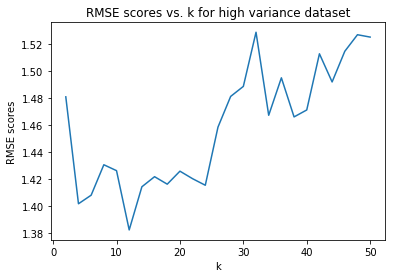

In [45]:
plt.figure()
plt.plot(ks, rmse_highvar_scores)
plt.title('RMSE scores vs. k for high variance dataset')
plt.xlabel('k')
plt.ylabel('RMSE scores')
plt.show()

In [46]:
print('Best k for RMSE: {}'.format(ks[np.argmin(rmse_highvar_scores)]))

Best k for RMSE: 12


#### Question 22

In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from surprise import NMF
from surprise.model_selection import train_test_split

In [3]:
thresholds = [2.5, 3, 3.5, 4]
best_k = 16

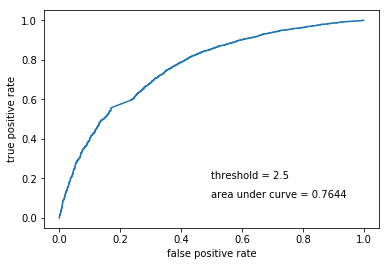

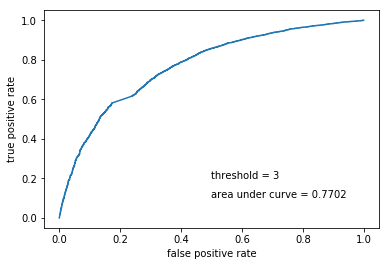

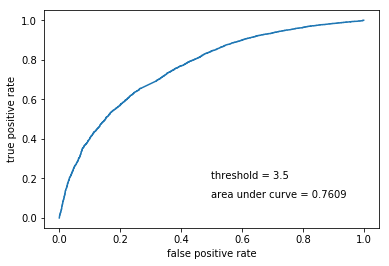

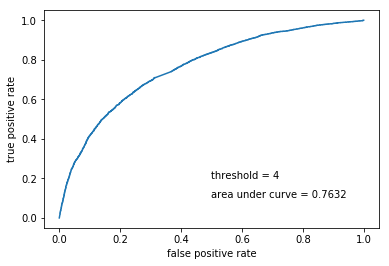

In [38]:
nmf = NMF(n_factors=best_k)
trainset, testset = train_test_split(rating_dataset, test_size=0.1)
nmf.fit(trainset)
predictions = nmf.test(testset)
for t in thresholds:
    true_bin = [1 if pred.r_ui >= t else 0 for pred in predictions]
    scores = [pred.est for pred in predictions]
    
    plt.figure()
    fpr, tpr, thr = roc_curve(true_bin, scores)
    plt.plot(fpr, tpr)
    plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(true_bin, scores))
    plt.text(0.5, 0.2, 'threshold = {}'.format(t))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()

#### Question 23

In [43]:
from surprise import NMF

In [46]:
nmf = NMF(n_factors=20)

#### Question 30

Filter original R matrix into popular, unpopular, and high-variance datasets

In [106]:
print('Original', R.shape)

def get_popular_z(R):
    counts_per_movie = np.sum(R != 0, axis=0)
    popular_ones = counts_per_movie > 2
    return R[:, popular_ones]
    
data_popular = get_popular_z(R)
print('Popular movies:', data_popular.shape)

def get_unpopular_z(R):
    counts_per_movie = np.sum(R != 0, axis=0)
    popular_ones = counts_per_movie <= 2
    return R[:, popular_ones]
    
data_unpopular = get_unpopular_z(R)
print('Unpopular movies:', data_unpopular.shape)

def get_highvar_z(R):
    counts_per_movie = np.sum(R != 0, axis=0)
    count_popular = counts_per_movie >= 5
    
    variances_per_movie = np.var(R, axis=0)
    high_var = variances_per_movie >= 2
    
    return R[:, np.all([count_popular, high_var], axis=0)]

data_highvar = get_highvar_z(R)
print('High-var movies:', data_highvar.shape)

Original (610, 9724)
Popular movies: (610, 4980)
Unpopular movies: (610, 4744)
High-var movies: (610, 138)


Custom cross validation function

In [107]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


def custom_crossval(X_train, y_train, model, num_folds=10, metrics=['RMSE', 'MAE', 'accuracy'],
                    randomize=True, include_inds=False):
    '''
    Requires a model that has the following functions:
        model.fit(X, y): fits the model on a particular set of X/y
        model.predict(X): predicts y given an input of X
    '''
    X_train_folds = []
    y_train_folds = []
    X_val_folds = []
    y_val_folds = []

    # necessary for some models (Naive)
    train_inds = []
    val_inds = []

    # initialize cumulative errors object
    cumulative_metrics = {}
    for met in metrics:
        cumulative_metrics[met] = 0

    k = num_folds

    ##############################################################################
    # 1. Divide dataset into training and validation folds
    idx = np.arange(X_train.shape[0])
    fold_size = X_train.shape[0] // num_folds

    # randomize indices
    if randomize:
        np.random.shuffle(idx)

    for i in range(num_folds):
        test_idx = idx[i * fold_size:(i + 1) * fold_size]
        train_idx = np.concatenate((idx[:i * fold_size:], idx[(i + 1) * fold_size:]))

        X_train_folds.append(X_train[train_idx])
        y_train_folds.append(y_train[train_idx])

        X_val_folds.append(X_train[test_idx])
        y_val_folds.append(y_train[test_idx])

        train_inds.append(train_idx)
        val_inds.append(test_idx)

    ##############################################################################
    # 2. Train on train set, test on validation set, calculate errors
    for i in range(len(X_train_folds)):
        # train model on the train folds (k-1 folds):
        model.fit(X_train_folds[i], y_train_folds[i])

        # measure error of test predictions
        if include_inds:
            y_pred = model.predict(X_val_folds[i], inds=val_inds[i])
        else:
            y_pred = model.predict(X_val_folds[i])

        # calculate errors:
        y_actual = y_val_folds[i]
        nonzero = np.nonzero(y_actual)
        for met in metrics:
            if met == 'RMSE':
                rms = sqrt(mean_squared_error(y_actual[nonzero], y_pred[nonzero]))
                cumulative_metrics[met] += rms
            elif met == 'MAE':
                mae = mean_absolute_error(y_actual[nonzero], y_pred[nonzero])
                cumulative_metrics[met] += mae
            elif met == 'accuracy':
                num_correct = np.sum(y_pred[nonzero] == y_actual[nonzero])
                cumulative_metrics[met] += num_correct / y_val_folds[i].shape[0]
            else:
                raise Exception("Error: requested error ('{}') is not incoporated into this function yet.".format(met))

    ##############################################################################
    # 3. Average and return metrics object
    for met in metrics:
        cumulative_metrics[met] = cumulative_metrics[met] / len(X_train_folds)
    return cumulative_metrics

##### Define Naive model

Calculate the average rating, $\mu_i$, for each user rating, $r_i$

In [116]:
class Naive():
    '''
    Custom collaborative filter designed to work with the cross-validation function
    '''

    # mean ratings, one required per user
    mu_i = None

    def __init__(self, X_train):
        self.mu_i = np.zeros(np.mean(X_train, axis=1).shape)
        self.fit(X_train, None, enabled=True)

    # calculate mu_i for training
    def fit(self, X, y, enabled=False):
        if enabled:
            for idx, row in enumerate(X):
                self.mu_i[idx] = np.mean(row[np.nonzero(row)])

    # return mu_i as rating prediction (for each movie)
    def predict(self, X, inds=None):
        if inds is None:
            return np.repeat(np.reshape(self.mu_i, (self.mu_i.shape[0], 1)), X.shape[1], axis=1)
        else:
            # return a specific set of mu_i's:
            return np.repeat(np.reshape(self.mu_i[inds], (self.mu_i[inds].shape[0], 1)), X.shape[1], axis=1)

In [117]:
model = Naive(R)
mu_i = model.mu_i
print("average rating shape:", mu_i.shape, "- should be", num_users)
print("average rating range:", np.min(mu_i), np.max(mu_i))

# print("\nshould match manual calculation:")
# mu_i = np.mean(data, axis=1)
# print("average rating shape:", mu_i.shape, "- should be", num_users)
# print("average rating range:", np.min(mu_i), np.max(mu_i))

y_pred = model.predict(R)
print(R.shape, y_pred.shape)

average rating shape: (610,) - should be 610
average rating range: 1.275 5.0
(610, 9724) (610, 9724)


In [118]:
error = custom_crossval(R, R, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE:', error['RMSE'])

Average RMSE: 0.937347784400813


#### Question 31

In [119]:
# model = Naive(data_popular)
error = custom_crossval(data_popular, data_popular, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE unpopular-trimmed data:', error['RMSE'])

Average RMSE unpopular-trimmed data: 0.9345684080583767


#### Question 32

In [120]:
# model = Naive(data_unpopular)
error = custom_crossval(data_unpopular, data_unpopular, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE unpopular-trimmed data:', error['RMSE'])

Average RMSE unpopular-trimmed data: 0.9921811809365859


#### Question 33

In [121]:
# model = Naive(data_highvar)
error = custom_crossval(data_highvar, data_highvar, model, num_folds=10, metrics=['RMSE'],
                        randomize=False, include_inds=True)

print('Average RMSE high-variance-trimmed data:', error['RMSE'])

Average RMSE high-variance-trimmed data: 0.9199148721031678
